In [1]:
from os import listdir
import pickle
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from matplotlib import pyplot as plt

def pickle_read(path):
    with open(path, 'rb') as f:
        
        data = pickle.load(f)
        return data


graph1
(2, 40, 100)
0
499


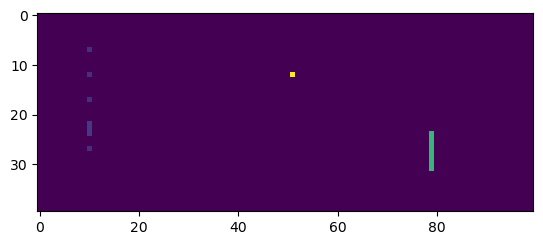

In [3]:
graph = listdir("graph")

graph_data = []
graph_label = []

for dir_path in graph:
    
    #if (int(dir_path[len(dir_path) - 1]) > 9 or len(dir_path) >= 7): continue
    print(dir_path)
    for data_path in listdir("graph" + '/' + dir_path):
        datas = pickle_read("graph" + '/' + dir_path + '/' + data_path)
        for data in datas:
            graph_data.append(np.array(data[0]))
            graph_label.append(data[1])




print(graph_data[0].shape)
print(graph_label[0])
print(len(graph_data))

plt.imshow(graph_data[300][1])
plt.show()


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

batch = 128
# 转换为PyTorch张量
graph_data_tensor = torch.tensor(np.array(graph_data), dtype=torch.double)
graph_label_tensor = torch.tensor(np.array(graph_label), dtype=torch.long)

# 创建TensorDataset和DataLoader
dataset = TensorDataset(graph_data_tensor, graph_label_tensor)
data_loader = DataLoader(dataset, batch_size=batch, shuffle=True)

for x, y in data_loader:
    print(x.shape)
    print(y.shape)
    break

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv = nn.Sequential(nn.Conv2d(2, 16, kernel_size=3, padding=1, stride=2),
                                  nn.ReLU(),
                                  nn.Conv2d(16, 64, kernel_size=3, padding=1, stride=2),
                                  nn.ReLU(),)

        fc_sample = torch.zeros((2, 40, 100))
        self.fc_input = len(torch.flatten(self.conv(fc_sample)))

        self.fc = nn.Sequential(nn.Linear(self.fc_input, 1024),
                                nn.ReLU(),
                                nn.Linear(1024, 3))
        
    
    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
    



In [ ]:
import torch.optim as optim

use_gpu = torch.cuda.is_available()


model = SimpleCNN()#要跟讀取的模型同個結構


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
min_loss = 1e9

if (use_gpu):
    model = model.to(device="cuda", dtype=torch.double)
    criterion = criterion.to(device="cuda", dtype=torch.double)

model

In [ ]:
max_acc = 0

In [ ]:

for epoch in range(1000): 
    running_loss = 0.0
    correct = 0
    total = 0

    
    batch_count = 0
    for inputs, labels in data_loader:
        #print(f"batch:{batch_count}")
        if (use_gpu):
            inputs, labels = inputs.to(device="cuda", dtype=torch.double), labels.to(device="cuda", dtype=torch.long)
        
        optimizer.zero_grad()  # 清空梯度
        outputs = model(inputs)  # 前向传播
        loss = criterion(outputs, labels)  # 计算损失
        loss.backward()  # 反向传播
        optimizer.step()  # 更新权重
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)  # 获取预测结果
        total += labels.size(0)  # 更新总样本数
        correct += (predicted == labels).sum().item()  # 更新正确预测的样本数
        
        # for i in range(len(predicted)):
        #     if (predicted[i] != labels[i]):
        #         print(f"No:{i}, predict:{predicted[i]}, label:{int(labels[i])}", end=" ")
        batch_count += 1
        
    epoch_loss = running_loss / len(data_loader)
    epoch_acc = 100 * correct / total  # 计算准确率
    print()
    if (max_acc < epoch_acc):
        
        torch.save(model.state_dict() ,"checkpoint_cls.pth" )
        print(f"save model, old_acc:{max_acc}, new_acc:{epoch_acc}")
        max_acc = epoch_acc

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.3f}%")